# PHYS 512 - Problem Set 7

**André Vallières (260742187)**

## Problem 1

Let $t$ represent time steps, thus we let $t \pm dt = t \pm 1$. Hence, we have

\begin{equation}
\frac{f(x, t + 1) - f(x, t - 1)}{2\ dt} = -v \frac{f(x + dx, t) - f(x - dx, t)}{2\ dx}
\end{equation}

Then we let $f(x,t) = \xi^t e^{ikx}$ and plug it in the equation

\begin{align}
\frac{\xi^{t + 1} e^{ikx} - \xi^{t - 1} e^{ikx}}{2\ dt} &= -v \frac{\xi^t e^{ikx} e^{ikdx} - \xi^t e^{ikx} e^{-ikdx}}{2\ dx}\\
\xi - \xi^{-1} &= -C (e^{ikdx} - e^{-ikdx})\\
\xi - \xi^{-1} &= -2iC \sin(kdx)
\end{align}

where $C = v\ dt/dx$ is the Courant number. Solving for a second-order equation in $\xi$ yields

\begin{equation}
\xi^2 + 2i \xi C \sin(kdx) - 1 = 0
\end{equation}

which has solutions

\begin{equation}
\xi = -iC \sin(kdx) \pm \sqrt{1 - C^2 \sin^2(kdx)}
\end{equation}

Computing its magnitude squared

\begin{equation}
|\xi|^2 = C^2 \sin^2(kdx) + 1 - C^2 \sin^2(kdx) = 1
\end{equation}

given $1 - C^2 \sin^2(kdx) > 0 \Rightarrow C < 1$, or the CFL condition is satisfied. Hence, no amplitude dissipation using leapfrog given the CFL condition is satisfied, so energy is conserved.

## Problem 2

### a) Finding the potential for a point charge

In [256]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

In [257]:
# Set up the grid
n = 256
x = np.arange(n)
x[n//2:] = x[n//2:] - n
xx,yy = np.meshgrid(x, x)

# Set up initial guess for potential
r = np.sqrt(xx**2 + yy**2)
r[0,0] = 1 # Remove singularity at (0, 0)
V = np.log(r)/(2*np.pi)

# Set V at (0, 0)
V[0,0] = 0.25 * (V[1,0] + V[-1,0] + V[0,1] + V[0,-1])

# Set potential at the edges to go to zero
V = V - V[n//2, n//2]

# Compute V[0, 0]
V[0,0] = 4 * V[1,0] - V[2,0] - V[1,1] - V[1,-1]

# Compute rho
def average(V):
    return (np.roll(V,1,0) + np.roll(V,-1,0) + np.roll(V,1,1) + np.roll(V,-1,1)) / 4
def compute_rho(V):
    return V - average(V)
    
rho = compute_rho(V)

# Rescale V to rho[0,0] = V[0,0] = 1
V = V/rho[0,0]
V = V - V[0,0] + 1
rho = compute_rho(V)

# Print values
print("rho[0,0]:", rho[0,0])
print("V[0,0]:", V[0,0])
print("V[1,0]:", V[1,0])
print("V[2,0]:", V[2,0])
print("V[5,0]:", V[5,0])

rho[0,0]: 1.0
V[0,0]: 1.0
V[1,0]: 0.0
V[2,0]: -0.5000000000000004
V[5,0]: -1.1609640474436813


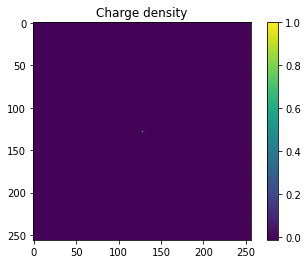

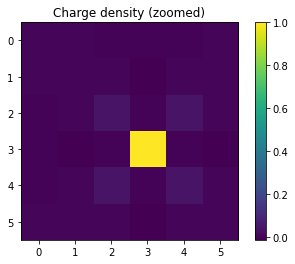

In [258]:
def wrap_for_image(img):
    return np.roll(img, img.shape[0]//2, axis=(0,1))

plt.title("Charge density")
plt.imshow(wrap_for_image(rho))
plt.colorbar()
plt.show()

plt.title("Charge density (zoomed)")
plt.imshow(wrap_for_image(rho)[n//2 - 3:n//2 + 3, n//2 - 3:n//2 + 3])
plt.colorbar()
plt.show()

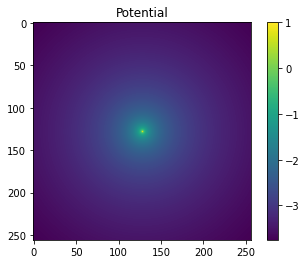

In [259]:
plt.title("Potential")
plt.imshow(wrap_for_image(V))
plt.colorbar()
plt.show()

### b) Using Green's function to calculate charge density of a square box

In [260]:
# Set up grid
N = n//2
bc = np.zeros([N,N])
mask = np.zeros([N,N], dtype='bool')

bc[0,:] = 0.0
bc[-1,:] = 0.0
bc[:,0] = 0.0
bc[:,-1] = 0.0

mask[0,:] = True
mask[-1,:] = True
mask[:,0] = True
mask[:,-1] = True

# Place square box at fixed potential
bc[3*N//8:5*N//8,3*N//8:5*N//8] = 1.0
mask[3*N//8:5*N//8,3*N//8:5*N//8] = True

# FT of point charge potential
kernel = V.copy()
kernelft = np.fft.rfft2(kernel)

In [261]:
def compute_V_fft(rho, kernelft, mask, out_mask=True):
    # Initialize rho
    rhomat = np.zeros(mask.shape)
    rhomat_shape = rhomat.shape
    rhomat[mask] = rho

    # Compute potential by convoluting the kernel with rho
    rhomat = np.pad(rhomat, (0, rhomat.shape[0]))
    
    rhomatft = np.fft.rfftn(rhomat)
    V = np.fft.irfftn(rhomatft * kernelft) # Convolution to find V
    
    # Return portion of interest
    V = V[:rhomat_shape[0],:rhomat_shape[1]]
    
    if out_mask:
        return V[mask]
    else:
        return V
    
def cg(V_masked, rho, mask, kernelft, niter = 50):
    # Conjugate gradient - from notes
    V_guess = compute_V_fft(rho, kernelft, mask)
    r = V_masked - V_guess
    
    p = r.copy()
    x = rho.copy()
    rsqr = np.sum(r*r)
    
    print('Starting rsqr is', rsqr)
    for k in range(niter):
        Ap = compute_V_fft(p, kernelft, mask)
        alpha = np.sum(r*r)/np.sum(Ap*p)
        x = x + alpha*p
        r = r - alpha*Ap
        rsqr_new = np.sum(r*r)
        beta = rsqr_new/rsqr
        p = r + beta*p
        rsqr = rsqr_new
    print('Final rsqr is', rsqr)
    
    return x

Starting rsqr is 1024.0
Final rsqr is 5.756350985902968e-10


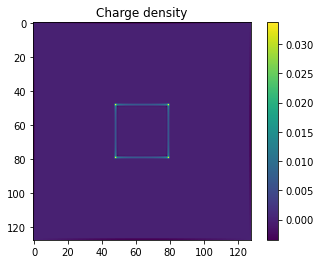

In [262]:
# Initialize parameters
V_masked = bc[mask]
rho_start = 0 * V_masked

# Run conjugate gradient
final_rho = cg(V_masked, rho_start, mask, kernelft)
rhomat = np.zeros(mask.shape)
rhomat_shape = rhomat.shape
rhomat[mask] = final_rho

# Plot charge density
plt.title("Charge density")
plt.imshow(rhomat)
plt.colorbar()
plt.show()

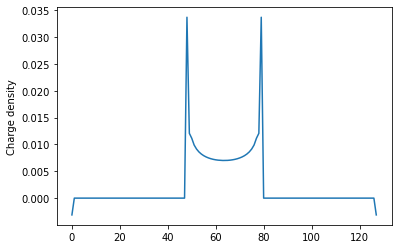

In [263]:
# Plotting along one side of the box
rho_side = rhomat[:,5*N//8-1]

plt.plot(rho_side)
plt.ylabel("Charge density")
plt.show()

We clearly see the accumulation of charge at the corners of the square box.

### c) Plotting potential

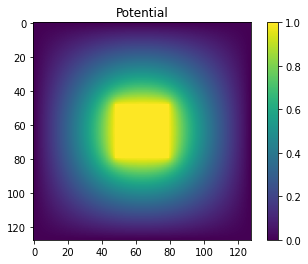

In [264]:
# Plot potential
pot = compute_V_fft(final_rho, kernelft, mask, out_mask=False)

plt.title("Potential")
plt.imshow(pot)
plt.colorbar()
plt.show()

In [265]:
# Plot statistics on potential inside the box
pot_inside = pot[bc == 1.0]

print("Mean:", np.mean(pot_inside))
print("Standard deviation:", np.std(pot_inside))

Mean: 1.0000000624436807
Standard deviation: 6.60342436069819e-07


Very close to constant inside the box!

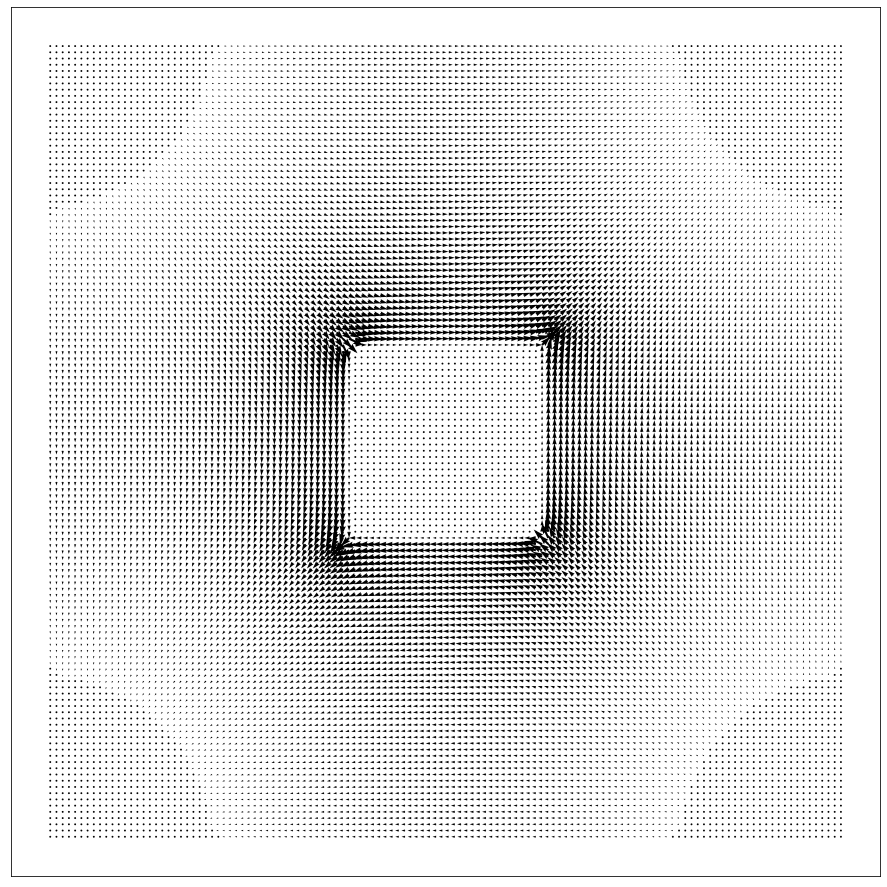

In [266]:
# Compute electric field
dx, dy = np.gradient(pot)
Ex, Ey = -dx, -dy

# Plot
x = np.arange(pot.shape[0])
X, Y = np.meshgrid(x, x)

fig, ax = plt.subplots(figsize=(16,16))
ax.quiver(X, Y, Ex, Ey)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.set_aspect('equal')
plt.show()

Agree with theory! Field is perpendicular to equipotential (i.e., arrows are parallel to the square box borders) and field is stronger at the corners. 